In [191]:
# estatísticas básicas
import seaborn as sea
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



file_name = '../measurements.csv'
df = pd.read_csv(file_name, header = 0, delimiter=",", decimal=".")
df['Language'].replace('CSharp', 'C#', inplace=True)
df['Time'] = df['Time'] / 1000
df.head()

,Language,Program,PowerLimit,Package,Core,GPU,DRAM,Time,Temperature,Memory
0,Ada,binary-trees,-1,103.249634,77.210144,0.0,9.470093,2.783,28.8,202904.0
1,Ada,binary-trees,-1,102.630920,76.057190,0.0,9.618042,2.844,28.2,202908.0
2,Ada,binary-trees,-1,102.921081,76.936951,0.0,9.476868,2.782,29.8,202900.0
3,Ada,binary-trees,-1,103.698730,78.182007,0.0,9.302795,2.738,29.8,202796.0
4,Ada,binary-trees,-1,104.284241,77.472168,0.0,9.556763,2.865,30.8,202912.0


In [192]:
df = df[df['Time'] != 'error']

In [193]:
# List of variables to be cast to float
variables_to_cast = ['Package', 'Core', 'GPU', 'DRAM', 'Time', 'Temperature', 'Memory']

# Iterate through the specified variables and cast them to float
for variable in variables_to_cast:
    df[variable] = pd.to_numeric(df[variable], errors='coerce').astype(float)

df['Program'] = df['Program'].str.lstrip()
# Display the modified DataFrame
df.head()


,Language,Program,PowerLimit,Package,Core,GPU,DRAM,Time,Temperature,Memory
0,Ada,binary-trees,-1,103.249634,77.210144,0.0,9.470093,2.783,28.8,202904.0
1,Ada,binary-trees,-1,102.630920,76.057190,0.0,9.618042,2.844,28.2,202908.0
2,Ada,binary-trees,-1,102.921081,76.936951,0.0,9.476868,2.782,29.8,202900.0
3,Ada,binary-trees,-1,103.698730,78.182007,0.0,9.302795,2.738,29.8,202796.0
4,Ada,binary-trees,-1,104.284241,77.472168,0.0,9.556763,2.865,30.8,202912.0


In [194]:
df.dtypes

Language        object
Program         object
PowerLimit       int64
Package        float64
Core           float64
GPU            float64
DRAM           float64
Time           float64
Temperature    float64
Memory         float64
dtype: object

# Analise dos dados

In [195]:
dfAnalise = df.drop(['GPU', 'Core','DRAM'], axis=1)

In [196]:
dfAnalise.shape[0]

20900

## Tratamento

### Remover extremos

In [197]:
group_columns = ['Language', 'Program','PowerLimit']
value_column = 'Package'
n_values_to_remove = 3

# Define a function to remove the lowest and highest values within each group
def remove_extremes(group):
    sorted_group = group.sort_values(value_column)
    return sorted_group.iloc[n_values_to_remove:-n_values_to_remove]

# Apply the function within each group using groupby with multiple columns
dfAnalise = dfAnalise.groupby(group_columns, group_keys=False, sort=False).apply(remove_extremes)

In [198]:
dfAnalise.shape[0]

14636

### Remoção de linguagens que não têm todas as execuções

In [199]:
#Remoção do pidits e do Lisp (tem uma execução inválida)
dfAnalise = dfAnalise[dfAnalise['Program'] != 'pidigits']
dfAnalise = dfAnalise[dfAnalise['Language'] != 'Lisp']

In [200]:
languagesProgramImplm = {}
for language, group in dfAnalise.groupby('Language'):
    programs = group['Program'].unique().tolist()
    languagesProgramImplm[language] = programs
for language in languagesProgramImplm:
    print(language, " -> " , languagesProgramImplm[language])

Ada  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
C  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
C#  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
C++  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
Dart  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
Erlang  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
FSharp  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'spect

In [201]:
for language in languagesProgramImplm:
    languagesProgramImplm[language] = len(languagesProgramImplm[language])
    print(language, " -> " , languagesProgramImplm[language])

Ada  ->  9
C  ->  9
C#  ->  9
C++  ->  9
Dart  ->  9
Erlang  ->  9
FSharp  ->  8
Go  ->  9
Haskell  ->  9
Java  ->  9
JavaScript  ->  9
Julia  ->  9
Lua  ->  9
OCaml  ->  9
PHP  ->  9
Pascal  ->  8
Perl  ->  9
Python  ->  9
Racket  ->  9
Ruby  ->  9
Rust  ->  9
Swift  ->  9


In [202]:
dfAnalise = dfAnalise[dfAnalise['Language'] != 'FSharp']
dfAnalise = dfAnalise[dfAnalise['Language'] != 'Pascal']

## Analise

### Verificar em média qual é o powerlimit em que obtivemos melhores resultados

#### Each Language-Program best PowerLimit value minimize Package

In [203]:
group_columns = ['Language', 'Program','PowerLimit']
#languages = dfAnalise.groupby('Language', group_keys=False, sort=False)

dfBestPower = dfAnalise.groupby(group_columns)['Package'].mean().reset_index(name='Package')

# Sort the DataFrame by 'Package' in ascending order
dfBestPower = dfBestPower.sort_values(by='Package')

# Keep only the first row for each combination of 'Language' and 'Program'
dfBestPower = dfBestPower.groupby(['Language', 'Program']).first().reset_index()

# Display the result
dfBestPower.head(10)

,Language,Program,PowerLimit,Package
0,Ada,binary-trees,15,88.593070
1,Ada,fannkuch-redux,25,243.025391
2,Ada,fasta,15,43.239110
3,Ada,k-nucleotide,15,124.988883
4,Ada,mandelbrot,15,110.830335
5,Ada,n-body,15,90.635302
6,Ada,regex-redux,15,112.315648
7,Ada,reverse-complement,15,6.710593
8,Ada,spectral-norm,15,26.433943
9,C,binary-trees,15,34.545585


#### PowerLimit mode for each Language

In [204]:
# Group by 'Language' and calculate the mode for 'PowerLimit'
dfBestPower = dfBestPower.groupby('Language')['PowerLimit'].apply(lambda x: x.mode().iloc[0]).reset_index()
print(dfBestPower)

#With this table we can see that PowerLimit at 15 is the value that saves the most energy

      Language  PowerLimit
0          Ada          15
1            C          15
2           C#          15
3          C++          15
4         Dart          15
5       Erlang          15
6           Go          15
7      Haskell          15
8         Java          15
9   JavaScript          15
10       Julia          15
11         Lua          15
12       OCaml          15
13         PHP          15
14        Perl          15
15      Python          15
16      Racket          15
17        Ruby          15
18        Rust          15
19       Swift          15


### Ranking de Linguagens

#### Default Ranking Calculation

In [205]:
dfRanking = dfAnalise[['Language','Program','PowerLimit','Package','Time']]
dfRanking = dfRanking[dfRanking['PowerLimit'].isin([-1,15])]
dfRanking.rename(columns={'Package': 'Energy (J)'}, inplace=True)
dfRanking.rename(columns={'Time': 'Time (ms)'}, inplace=True)
dfRanking.head(5)

,Language,Program,PowerLimit,Energy (J),Time (ms)
12,Ada,binary-trees,-1,103.249390,2.804
0,Ada,binary-trees,-1,103.249634,2.783
19,Ada,binary-trees,-1,103.401611,2.777
3,Ada,binary-trees,-1,103.698730,2.738
15,Ada,binary-trees,-1,103.806030,2.770


#### Calcular Médias

In [206]:
dfRanking = dfRanking.groupby(['Language', 'Program', 'PowerLimit']).agg({'Energy (J)': 'mean', 'Time (ms)': 'mean'}).reset_index()
dfRanking.head(10)

,Language,Program,PowerLimit,Energy (J),Time (ms)
0,Ada,binary-trees,-1,104.080684,2.771286
1,Ada,binary-trees,15,88.593070,5.930571
2,Ada,fannkuch-redux,-1,282.892325,6.785500
3,Ada,fannkuch-redux,15,245.107631,16.399143
4,Ada,fasta,-1,44.873688,2.489571
5,Ada,fasta,15,43.239110,2.890429
6,Ada,k-nucleotide,-1,146.951468,5.500786
7,Ada,k-nucleotide,15,124.988883,8.363643
8,Ada,mandelbrot,-1,124.386819,3.616000
9,Ada,mandelbrot,15,110.830335,7.413857


In [207]:
dataset_power_no_limit = dfRanking[dfRanking['PowerLimit'] == -1].drop(columns=['PowerLimit'])
dataset_power_limit_15 = dfRanking[dfRanking['PowerLimit'] == 15].drop(columns=['PowerLimit'])

#### Ranking with not limitations

In [208]:
# Create a dictionary to store the sorted DataFrames for each program
dict_no_limit = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in dataset_power_no_limit.groupby('Program'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    dict_no_limit[program] = sorted_df

# Display the result (program_order_dict)
for program, sorted_df in dict_no_limit.items():
    print(f"Program: {program}")
    print(sorted_df[['Language', 'Energy (J)', 'Time (ms)']])  # Exclude 'Program' and 'PowerLimit' columns
    print("\n")


Program: binary-trees
      Language   Energy (J)  Time (ms)
0          C++    35.893250   0.889500
1            C    41.419778   1.030000
2         Rust    41.709355   0.976143
3      Haskell    48.777679   2.238929
4         Java    86.143917   2.215929
5          Ada   104.080684   2.771286
6       Racket   111.901746   4.079643
7        OCaml   129.308877   3.715643
8       Erlang   138.257525   3.826786
9   JavaScript   220.178271   5.738143
10        Dart   327.175585  10.538500
11       Julia   376.561288  14.328929
12          C#   414.455396  24.575286
13       Swift   453.466426  12.383071
14          Go   538.418566  11.831143
15         PHP   824.551518  20.531071
16        Ruby  1097.580318  29.156857
17        Perl  1475.272879  33.724286
18      Python  1522.273067  36.251857
19         Lua  1736.913775  43.028214


Program: fannkuch-redux
      Language    Energy (J)   Time (ms)
0            C     79.605242    2.114857
1           C#     80.111311    2.190214
2         

#### Ranking with PowerLimit 15

In [209]:
#Fazer o dicionário
# Create a dictionary to store the sorted DataFrames for each program
dict_limit_15 = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in dataset_power_limit_15.groupby('Program'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    dict_limit_15[program] = sorted_df

In [210]:
# Initialize an empty list to store the comparison results
comparison_results = []

# Iterate over programs in the first dictionary
for program, df1 in dict_limit_15.items():
    # Check if the program exists in the second dictionary
    if program in dict_no_limit:
        df2 = dict_no_limit[program]

        # Iterate over languages in the program
        for language in df1['Language']:
            # Extract data for the specific language in both dictionaries
            lang_df1 = df1[df1['Language'] == language]
            lang_df2 = df2[df2['Language'] == language]

            # Calculate the differences
            position_changes = lang_df1.index[0] - lang_df2.index[0]
            energy_difference = lang_df1['Energy (J)'].iloc[0] - lang_df2['Energy (J)'].iloc[0]
            time_difference = lang_df1['Time (ms)'].iloc[0] - lang_df2['Time (ms)'].iloc[0]

            # Append the results to the comparison list
            comparison_results.append({
                'Program': program,
                'Language': language,
                'Energy (J)': lang_df1['Energy (J)'].iloc[0],
                'Time (ms)': lang_df1['Time (ms)'].iloc[0],
                'Position Changes': position_changes,
                'Energy Difference': energy_difference,
                'Energy Difference %': energy_difference/lang_df2['Energy (J)'].iloc[0]*100,
                'Time Difference': time_difference,
                'Time Difference %': time_difference/lang_df2['Time (ms)'].iloc[0]*100
            })

# Convert the list of dictionaries into a DataFrame
dataset_power_limit_15 = pd.DataFrame(comparison_results)

# Display the comparison results
dataset_power_limit_15.head(10)

,Program,Language,Energy (J),Time (ms),Position Changes,Energy Difference,Energy Difference %,Time Difference,Time Difference %
0,binary-trees,C++,30.002563,2.007357,0,-5.890686,-16.411682,1.117857,125.672529
1,binary-trees,Rust,33.501059,2.241286,-1,-8.208296,-19.679747,1.265143,129.606322
2,binary-trees,C,34.545585,2.310571,1,-6.874193,-16.596403,1.280571,124.327323
3,binary-trees,Haskell,47.270813,3.294071,0,-1.506866,-3.089254,1.055143,47.127134
4,binary-trees,Java,62.719583,4.199714,0,-23.424334,-27.192093,1.983786,89.523902
5,binary-trees,Ada,88.593070,5.930571,0,-15.487614,-14.880392,3.159286,114.000722
6,binary-trees,Racket,91.678606,6.186786,0,-20.223140,-18.072229,2.107143,51.650179
7,binary-trees,OCaml,108.893106,7.284357,0,-20.415771,-15.788376,3.568714,96.045676
8,binary-trees,Erlang,115.088261,7.811714,0,-23.169264,-16.758049,3.984929,104.132524
9,binary-trees,JavaScript,182.375854,12.206357,0,-37.802416,-17.169004,6.468214,112.723131


In [211]:
#Fazer o dicionário
# Create a dictionary to store the sorted DataFrames for each program
dict_limit_15 = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in dataset_power_limit_15.groupby('Program'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    dict_limit_15[program] = sorted_df

# Display the result (program_order_dict)
for program, sorted_df in dict_limit_15.items():
    print(f"Program: {program}")
    print(sorted_df.drop(columns=['Program']))
    print("\n")

Program: binary-trees
      Language   Energy (J)  Time (ms)  Position Changes  Energy Difference  \
0          C++    30.002563   2.007357                 0          -5.890686   
1         Rust    33.501059   2.241286                -1          -8.208296   
2            C    34.545585   2.310571                 1          -6.874193   
3      Haskell    47.270813   3.294071                 0          -1.506866   
4         Java    62.719583   4.199714                 0         -23.424334   
5          Ada    88.593070   5.930571                 0         -15.487614   
6       Racket    91.678606   6.186786                 0         -20.223140   
7        OCaml   108.893106   7.284357                 0         -20.415771   
8       Erlang   115.088261   7.811714                 0         -23.169264   
9   JavaScript   182.375854  12.206357                 0         -37.802416   
10        Dart   267.052364  17.906500                 0         -60.123221   
11       Julia   335.743910  2

In [212]:
dfRanking_dict = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in dfRanking.groupby('Program'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    dfRanking_dict[program] = sorted_df

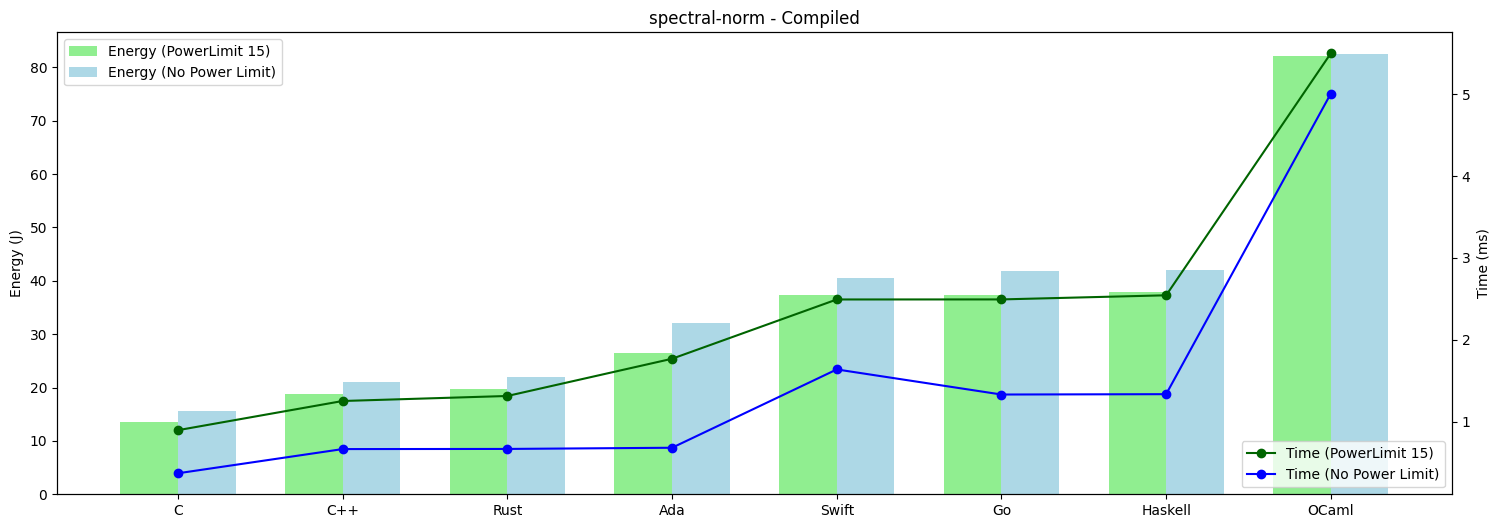

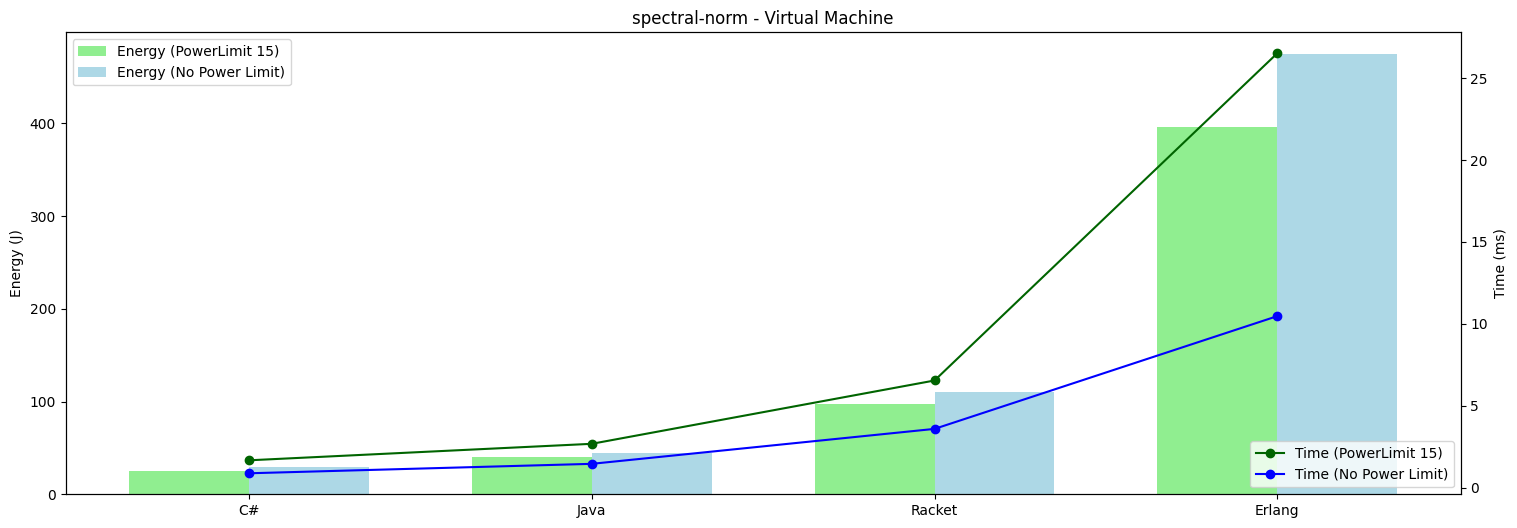

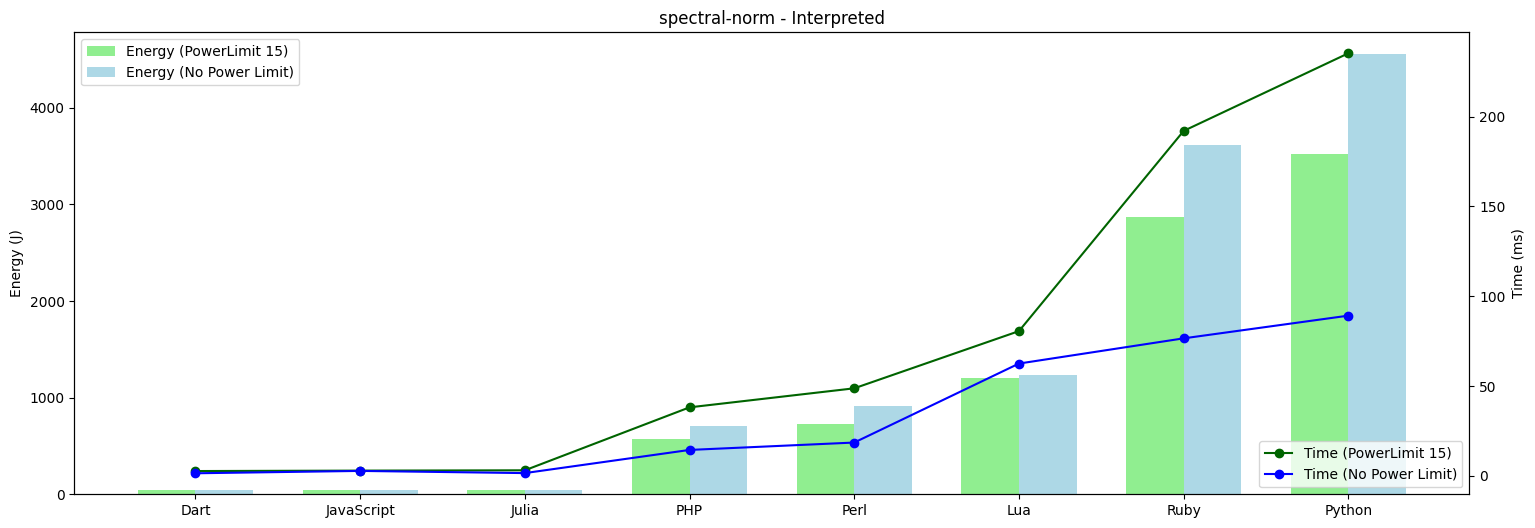

In [213]:
import matplotlib.pyplot as plt
import numpy as np

"""
array(['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide',
       'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement',
       'spectral-norm'], dtype=object)
"""

# Fix the problem variable
problem = "spectral-norm"

# Create a DataFrame to separate data by types
binaryTrees = dfRanking_dict[problem]
binaryTrees['Type'] = "undefined"

# Categorize languages by type
compiled_languages = ['Ada', 'C', 'C++', 'Go', 'Haskell', 'OCaml', 'Rust', 'Swift']
interpreted_languages = ['Dart', 'JavaScript', 'Lua', 'Perl', 'PHP', 'Python', 'Ruby', 'Julia']
vm_languages = ['C#', 'Erlang', 'Java', 'Racket']

binaryTrees.loc[binaryTrees['Language'].isin(compiled_languages), 'Type'] = "Compiled"
binaryTrees.loc[binaryTrees['Language'].isin(interpreted_languages), 'Type'] = "Interpreted"
binaryTrees.loc[binaryTrees['Language'].isin(vm_languages), 'Type'] = "Virtual Machine"

# Separate data by Type and PowerLimit
compiled_15_data = binaryTrees[(binaryTrees['Type'] == 'Compiled') & (binaryTrees['PowerLimit'] == 15)]
compiled_minus_1_data = binaryTrees[(binaryTrees['Type'] == 'Compiled') & (binaryTrees['PowerLimit'] == -1)]

vm_15_data = binaryTrees[(binaryTrees['Type'] == 'Virtual Machine') & (binaryTrees['PowerLimit'] == 15)]
vm_minus_1_data = binaryTrees[(binaryTrees['Type'] == 'Virtual Machine') & (binaryTrees['PowerLimit'] == -1)]

interpreted_15_data = binaryTrees[(binaryTrees['Type'] == 'Interpreted') & (binaryTrees['PowerLimit'] == 15)]
interpreted_minus_1_data = binaryTrees[(binaryTrees['Type'] == 'Interpreted') & (binaryTrees['PowerLimit'] == -1)]

# Function to plot data
def plot_data(ax, energy_15, time_15, energy_minus_1, time_minus_1, label):
    x = np.arange(len(energy_15))
    width = 0.35

    ax.bar(x - width/2, energy_15['Energy (J)'], width, color='lightgreen', label='Energy (PowerLimit 15)')
    ax.bar(x + width/2, energy_minus_1['Energy (J)'], width, color='lightblue', label='Energy (No Power Limit)')
    
    ax2 = ax.twinx()
    ax2.plot(x, energy_15['Time (ms)'], color='darkgreen', marker='o', label='Time (PowerLimit 15)')
    ax2.plot(x, time_minus_1['Time (ms)'], color='blue', marker='o', label='Time (No Power Limit)')
    
    ax.set_xticks(x)
    ax.set_xticklabels(energy_15['Language'])
    ax.set_ylabel('Energy (J)')
    ax2.set_ylabel('Time (ms)')
    ax.set_title(label)
    ax.legend(loc='upper left')
    ax2.legend(loc='lower right')  # Adjusting legend position

# Create three separate figures
fig1, ax1 = plt.subplots(figsize=(18, 6))
fig2, ax2 = plt.subplots(figsize=(18, 6))
fig3, ax3 = plt.subplots(figsize=(18, 6))

# Plot data for Compiled
plot_data(ax1, compiled_15_data, compiled_15_data, compiled_minus_1_data, compiled_minus_1_data, f'{problem} - Compiled')

# Plot data for Virtual Machine
plot_data(ax2, vm_15_data, vm_15_data, vm_minus_1_data, vm_minus_1_data, f'{problem} - Virtual Machine')

# Plot data for Interpreted
plot_data(ax3, interpreted_15_data, interpreted_15_data, interpreted_minus_1_data, interpreted_minus_1_data, f'{problem} - Interpreted')

# Show the plots
plt.show()


In [214]:
problem = "reverse-complement"
binaryTrees = dfRanking_dict[problem]
binaryTrees['Type'] = "undefined"
#sabicao

In [215]:
binaryTrees.loc[binaryTrees['Language'] == 'Ada', 'Type'] = "Compiled"
binaryTrees.loc[binaryTrees['Language'] == 'C', 'Type'] = "Compiled"
binaryTrees.loc[binaryTrees['Language'] == 'C++', 'Type'] = "Compiled"
binaryTrees.loc[binaryTrees['Language'] == 'Go', 'Type'] = "Compiled"
binaryTrees.loc[binaryTrees['Language'] == 'Haskell', 'Type'] = "Compiled"
binaryTrees.loc[binaryTrees['Language'] == 'OCaml', 'Type'] = "Compiled"
binaryTrees.loc[binaryTrees['Language'] == 'Rust', 'Type'] = "Compiled"
binaryTrees.loc[binaryTrees['Language'] == 'Swift', 'Type'] = "Compiled"

In [216]:
binaryTrees.loc[binaryTrees['Language'] == 'Dart', 'Type'] = "Interpreted"
binaryTrees.loc[binaryTrees['Language'] == 'JavaScript', 'Type'] = "Interpreted"
binaryTrees.loc[binaryTrees['Language'] == 'Lua', 'Type'] = "Interpreted"
binaryTrees.loc[binaryTrees['Language'] == 'Perl', 'Type'] = "Interpreted"
binaryTrees.loc[binaryTrees['Language'] == 'PHP', 'Type'] = "Interpreted"
binaryTrees.loc[binaryTrees['Language'] == 'Python', 'Type'] = "Interpreted"
binaryTrees.loc[binaryTrees['Language'] == 'Ruby', 'Type'] = "Interpreted"
binaryTrees.loc[binaryTrees['Language'] == 'Julia', 'Type'] = "Interpreted"

In [217]:
binaryTrees.loc[binaryTrees['Language'] == 'C#', 'Type'] = "Virtual Machine"
binaryTrees.loc[binaryTrees['Language'] == 'Erlang', 'Type'] = "Virtual Machine"
binaryTrees.loc[binaryTrees['Language'] == 'Java', 'Type'] = "Virtual Machine"
binaryTrees.loc[binaryTrees['Language'] == 'Racket', 'Type'] = "Virtual Machine"

In [218]:
binaryTrees.head(40)

,Language,Program,PowerLimit,Energy (J),Time (ms),Type
0,C,reverse-complement,15,1.903229,0.125714,Compiled
1,C,reverse-complement,-1,2.242868,0.093000,Compiled
2,C++,reverse-complement,15,2.605826,0.173214,Compiled
3,Rust,reverse-complement,15,2.731275,0.181429,Compiled
4,C++,reverse-complement,-1,2.858970,0.138929,Compiled
5,Rust,reverse-complement,-1,3.076364,0.108357,Compiled
6,C#,reverse-complement,15,3.786778,0.272571,Virtual Machine
7,C#,reverse-complement,-1,4.376552,0.174071,Virtual Machine
8,Ada,reverse-complement,15,6.710593,0.452500,Compiled
9,Ada,reverse-complement,-1,7.289228,0.335786,Compiled


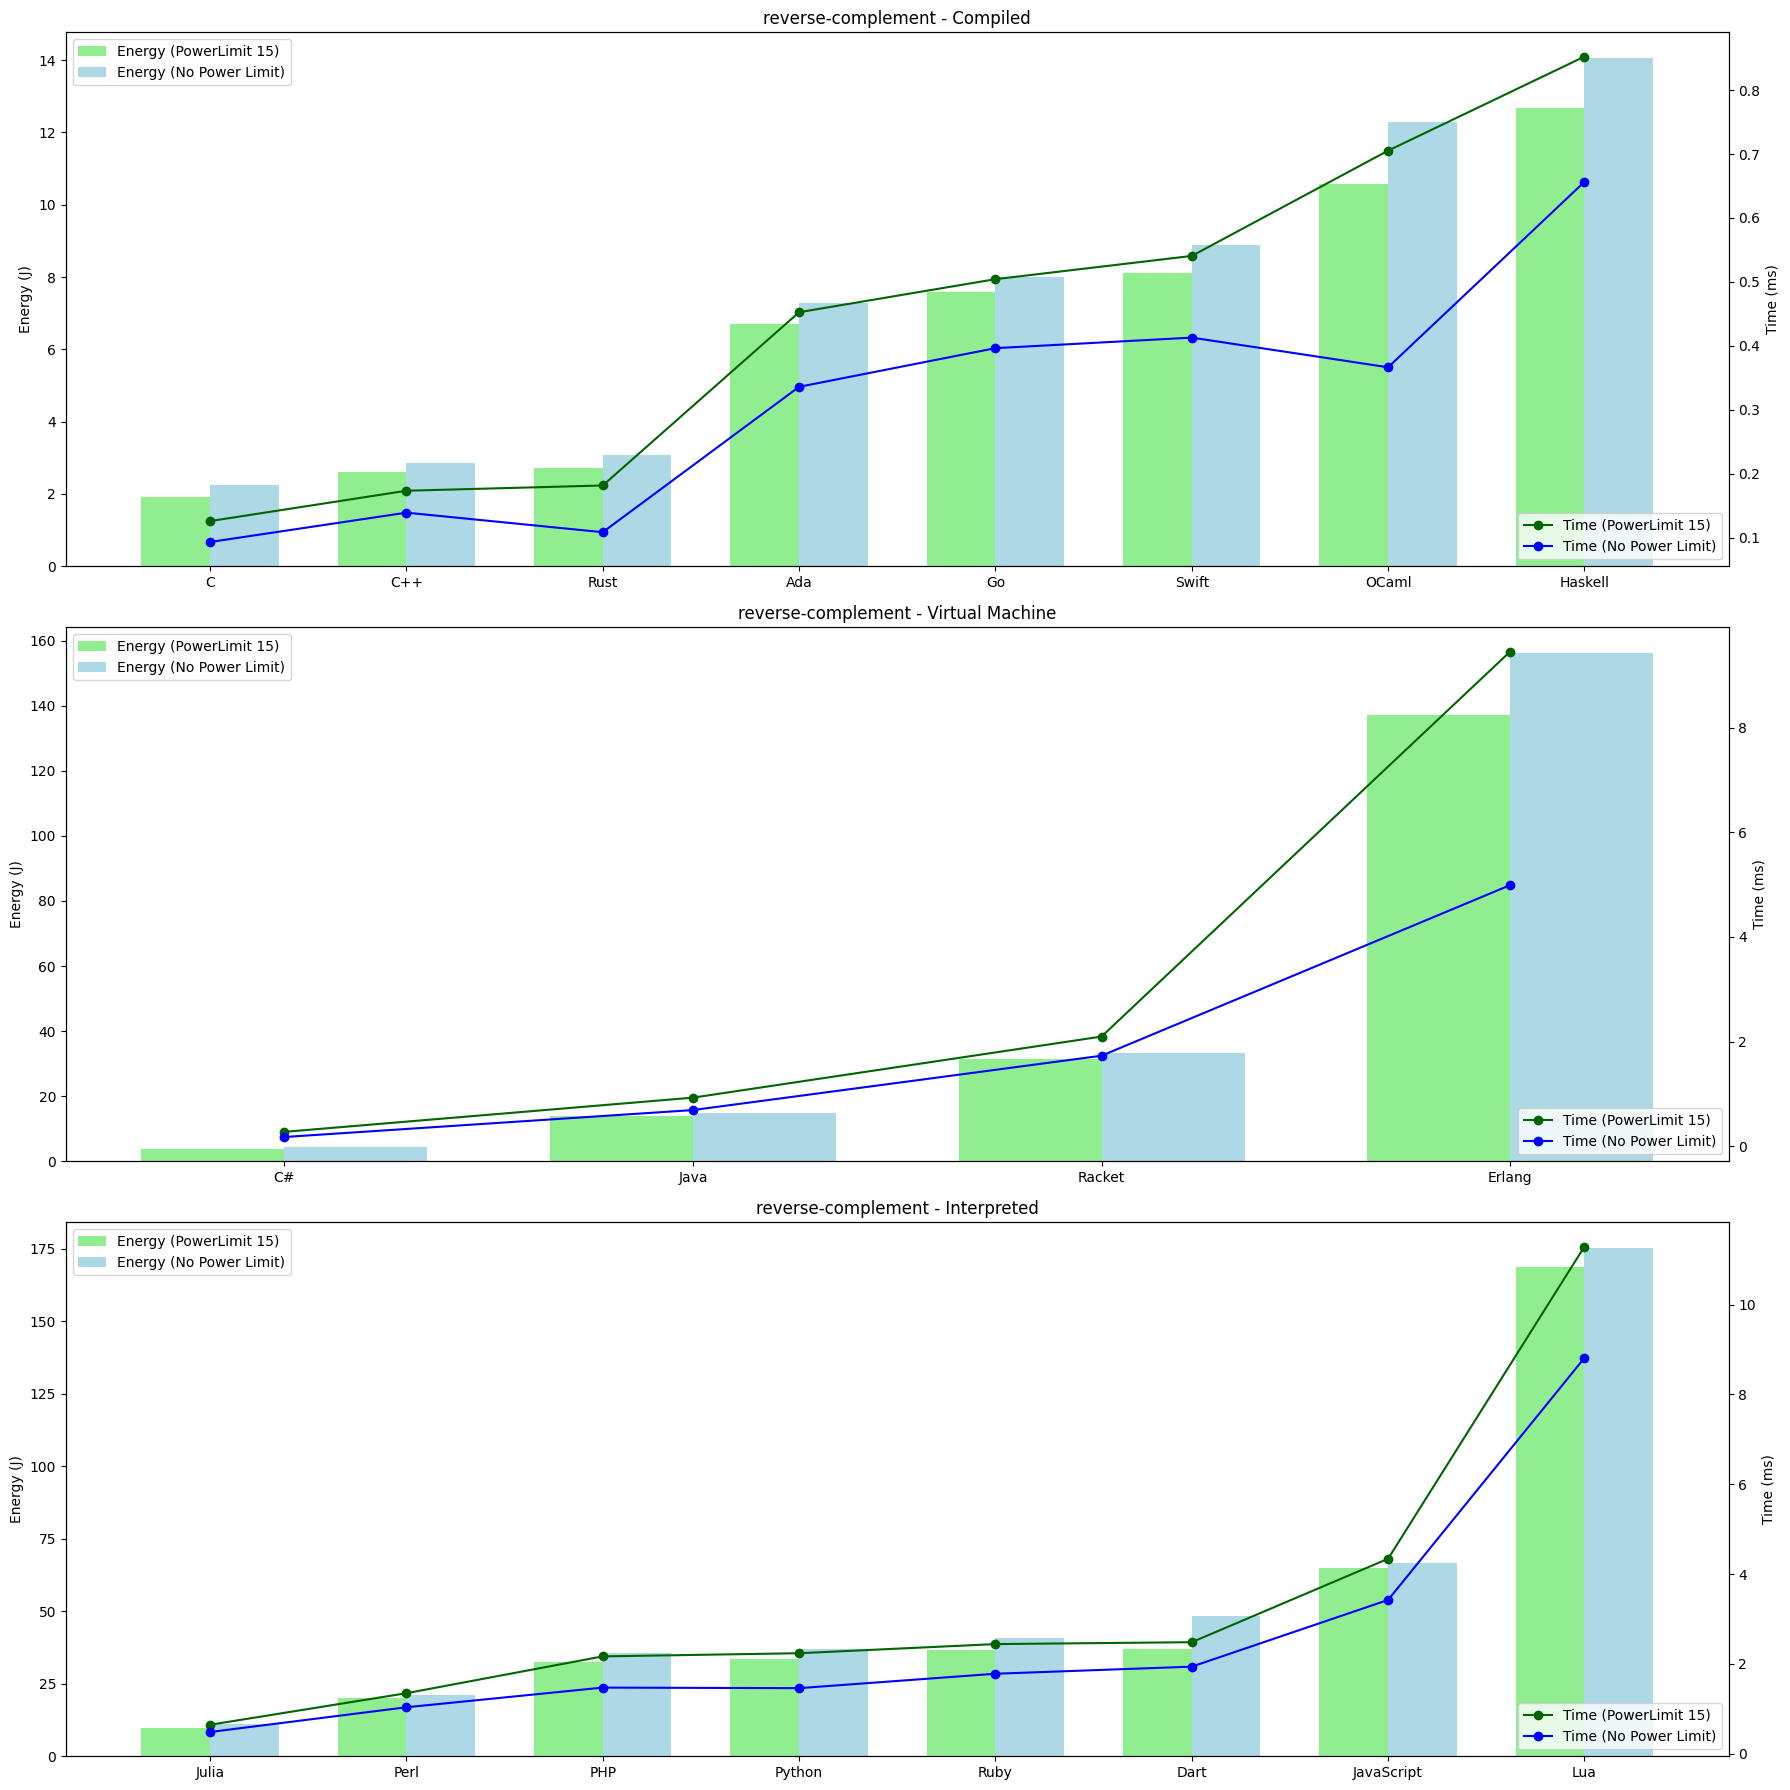

In [219]:
# Separate data by Type and PowerLimit
compiled_15_data = binaryTrees[(binaryTrees['Type'] == 'Compiled') & (binaryTrees['PowerLimit'] == 15)]
compiled_minus_1_data = binaryTrees[(binaryTrees['Type'] == 'Compiled') & (binaryTrees['PowerLimit'] == -1)]

vm_15_data = binaryTrees[(binaryTrees['Type'] == 'Virtual Machine') & (binaryTrees['PowerLimit'] == 15)]
vm_minus_1_data = binaryTrees[(binaryTrees['Type'] == 'Virtual Machine') & (binaryTrees['PowerLimit'] == -1)]

interpreted_15_data = binaryTrees[(binaryTrees['Type'] == 'Interpreted') & (binaryTrees['PowerLimit'] == 15)]
interpreted_minus_1_data = binaryTrees[(binaryTrees['Type'] == 'Interpreted') & (binaryTrees['PowerLimit'] == -1)]

# Function to plot data
def plot_data(ax, energy_15, time_15, energy_minus_1, time_minus_1, label):
    x = np.arange(len(energy_15))
    width = 0.35

    ax.bar(x - width/2, energy_15['Energy (J)'], width, color='lightgreen', label='Energy (PowerLimit 15)')
    ax.bar(x + width/2, energy_minus_1['Energy (J)'], width, color='lightblue', label='Energy (No Power Limit)')
    
    ax2 = ax.twinx()
    ax2.plot(x, energy_15['Time (ms)'], color='darkgreen', marker='o', label='Time (PowerLimit 15)')
    ax2.plot(x, time_minus_1['Time (ms)'], color='blue', marker='o', label='Time (No Power Limit)')
    
    ax.set_xticks(x)
    ax.set_xticklabels(energy_15['Language'])
    ax.set_ylabel('Energy (J)')
    ax2.set_ylabel('Time (ms)')
    ax.set_title(label)
    ax.legend(loc='upper left')
    ax2.legend(loc='lower right')  # Adjusting legend position


# Plotting
fig, axs = plt.subplots(3, 1, figsize=(18, 18))

plot_data(axs[0], compiled_15_data, compiled_15_data, compiled_minus_1_data, compiled_minus_1_data, f'{problem} - Compiled')
plot_data(axs[1], vm_15_data, vm_15_data, vm_minus_1_data, vm_minus_1_data, f'{problem} - Virtual Machine')
plot_data(axs[2], interpreted_15_data, interpreted_15_data, interpreted_minus_1_data, interpreted_minus_1_data, f'{problem} - Interpreted')

plt.tight_layout()
plt.show()

In [220]:
binaryTrees_dict = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in binaryTrees.groupby('Type'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    binaryTrees_dict[program] = sorted_df

# Display the result (program_order_dict)
for program, sorted_df in binaryTrees_dict.items():
    print(f"Program: {program}")
    print(sorted_df.drop(columns=['Program']))
    print("\n")

Program: Compiled
   Language  PowerLimit  Energy (J)  Time (ms)      Type
0         C          15    1.903229   0.125714  Compiled
1         C          -1    2.242868   0.093000  Compiled
2       C++          15    2.605826   0.173214  Compiled
3      Rust          15    2.731275   0.181429  Compiled
4       C++          -1    2.858970   0.138929  Compiled
5      Rust          -1    3.076364   0.108357  Compiled
6       Ada          15    6.710593   0.452500  Compiled
7       Ada          -1    7.289228   0.335786  Compiled
8        Go          15    7.573111   0.504214  Compiled
9        Go          -1    8.012464   0.396286  Compiled
10    Swift          15    8.108647   0.540571  Compiled
11    Swift          -1    8.876264   0.412786  Compiled
12    OCaml          15   10.564309   0.705286  Compiled
13    OCaml          -1   12.275216   0.366357  Compiled
14  Haskell          15   12.673375   0.852429  Compiled
15  Haskell          -1   14.065948   0.656429  Compiled


Program: In

### Gráficos finais com somas

In [221]:
#dfSomasPrograms = dfRanking.groupby(['Language' , 'Program' ,'PowerLimit']).agg({'Energy (J)': 'mean', 'Time (ms)': 'mean'}).reset_index()
dfSomasPrograms = dfRanking.groupby(['Language' ,'PowerLimit']).agg({'Energy (J)': 'sum', 'Time (ms)': 'sum'}).reset_index()
dfSomasPrograms.head(5)

,Language,PowerLimit,Energy (J),Time (ms)
0,Ada,-1,965.524166,31.068286
1,Ada,15,848.854514,56.797500
2,C,-1,367.654096,11.430429
3,C,15,316.371634,21.146071
4,C#,-1,946.813529,42.561714


In [222]:
dataset_power_no_limit = dfSomasPrograms[dfRanking['PowerLimit'] == -1].drop(columns=['PowerLimit'])
dataset_power_limit_15 = dfSomasPrograms[dfRanking['PowerLimit'] == 15].drop(columns=['PowerLimit'])

/tmp/ipykernel_4468/2430238798.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_power_no_limit = dfSomasPrograms[dfRanking['PowerLimit'] == -1].drop(columns=['PowerLimit'])
/tmp/ipykernel_4468/2430238798.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_power_limit_15 = dfSomasPrograms[dfRanking['PowerLimit'] == 15].drop(columns=['PowerLimit'])


#### Gráficos finais com somas (no limit)

In [223]:
dataset_power_no_limit = dataset_power_no_limit.sort_values(by='Energy (J)').reset_index(drop=True)
dataset_power_no_limit.head(20)
#TODO

,Language,Energy (J),Time (ms)
0,C++,363.094875,11.687000
1,C,367.654096,11.430429
2,Rust,689.356873,19.998857
3,C#,946.813529,42.561714
4,Ada,965.524166,31.068286
5,Java,1144.926470,32.755786
6,Julia,1272.131326,60.489143
7,OCaml,1471.454647,48.775143
8,Go,1524.454882,41.088429
9,JavaScript,1598.456948,50.357929


In [224]:
# Define the reference values for Energy and Time
reference_energy = dataset_power_no_limit.loc[0, 'Energy (J)']
reference_time = dataset_power_no_limit.loc[0, 'Time (ms)']

# Normalize Energy and Time columns
dataset_power_no_limit_normalized = dataset_power_no_limit.copy()
dataset_power_no_limit_normalized['Energy Normalized'] = dataset_power_no_limit_normalized['Energy (J)'] / reference_energy
dataset_power_no_limit_normalized['Time Normalized'] = dataset_power_no_limit_normalized['Time (ms)'] / reference_time
dataset_power_no_limit_normalized = dataset_power_no_limit_normalized.drop(columns=['Energy (J)','Time (ms)'])
dataset_power_no_limit_normalized.head(20)
#TODO

,Language,Energy Normalized,Time Normalized
0,C++,1.000000,1.000000
1,C,1.012557,0.978046
2,Rust,1.898559,1.711205
3,C#,2.607620,3.641800
4,Ada,2.659151,2.658363
5,Java,3.153243,2.802754
6,Julia,3.503578,5.175763
7,OCaml,4.052535,4.173453
8,Go,4.198503,3.515738
9,JavaScript,4.402312,4.308884


#### Gráficos finais com somas (limit = 15)

In [225]:
dataset_power_limit_15 = dataset_power_limit_15.sort_values(by='Energy (J)').reset_index(drop=True)
dataset_power_limit_15.head(20)

,Language,Energy (J),Time (ms)
0,C,316.371634,21.146071
1,C++,320.768877,21.441143
2,Rust,604.137944,40.398786
3,Ada,848.854514,56.797500
4,C#,865.582267,61.891429
5,Java,991.363586,66.314357
6,Julia,1192.361145,79.812143
7,OCaml,1268.793784,84.861286
8,Go,1319.209922,88.226786
9,JavaScript,1388.458078,92.929214


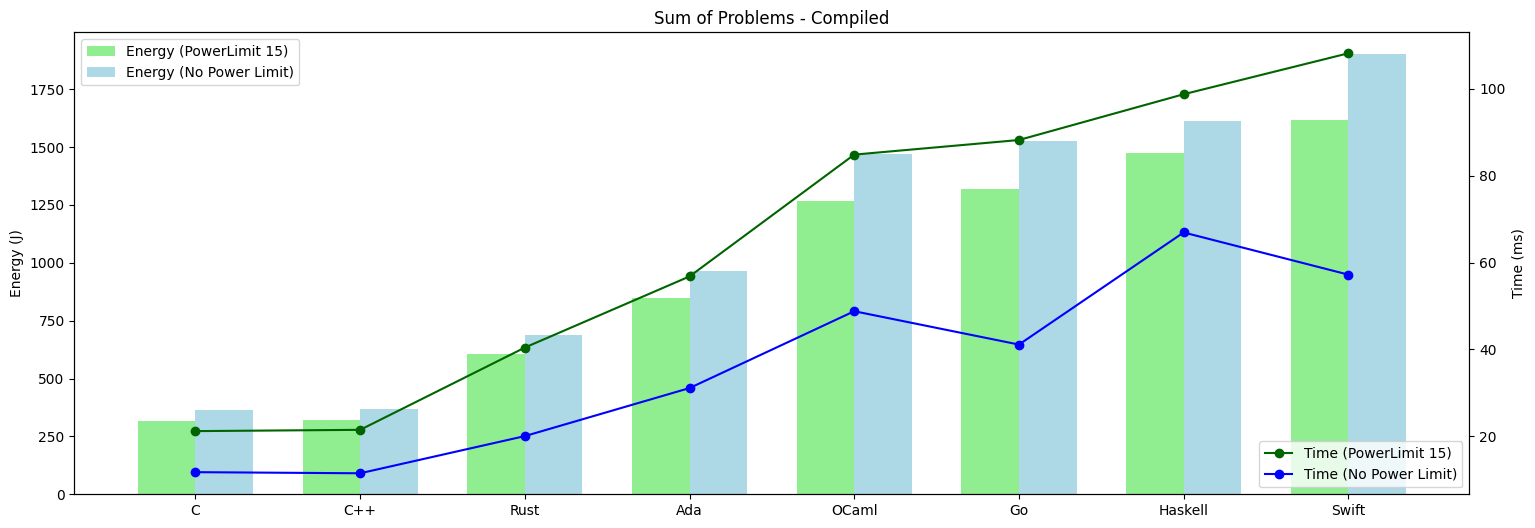

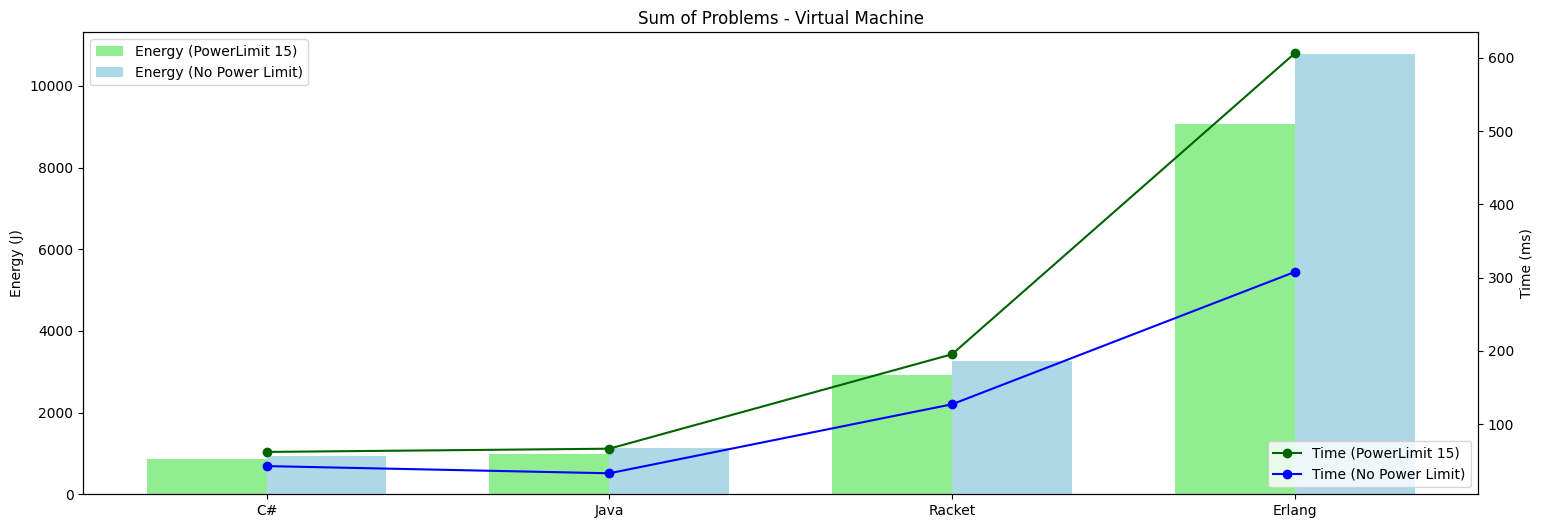

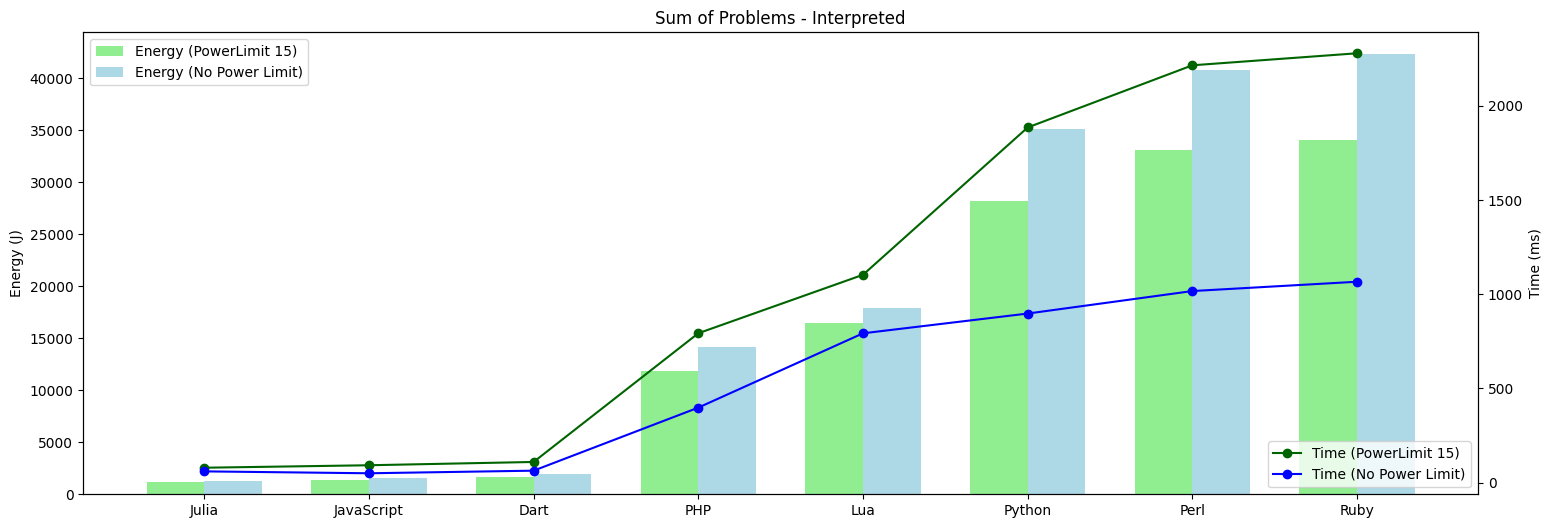

In [226]:
#sabicao
dataset_power_no_limit['Type'] = "undefined"
dataset_power_limit_15['Type'] = "undefined"

# Categorize languages by type
compiled_languages = ['Ada', 'C', 'C++', 'Go', 'Haskell', 'OCaml', 'Rust', 'Swift']
interpreted_languages = ['Dart', 'JavaScript', 'Lua', 'Perl', 'PHP', 'Python', 'Ruby', 'Julia']
vm_languages = ['C#', 'Erlang', 'Java', 'Racket']

dataset_power_no_limit.loc[dataset_power_no_limit['Language'].isin(compiled_languages), 'Type'] = "Compiled"
dataset_power_no_limit.loc[dataset_power_no_limit['Language'].isin(interpreted_languages), 'Type'] = "Interpreted"
dataset_power_no_limit.loc[dataset_power_no_limit['Language'].isin(vm_languages), 'Type'] = "Virtual Machine"
dataset_power_limit_15.loc[dataset_power_limit_15['Language'].isin(compiled_languages), 'Type'] = "Compiled"
dataset_power_limit_15.loc[dataset_power_limit_15['Language'].isin(interpreted_languages), 'Type'] = "Interpreted"
dataset_power_limit_15.loc[dataset_power_limit_15['Language'].isin(vm_languages), 'Type'] = "Virtual Machine"

# Separate data by Type and PowerLimit
compiled_15_data = dataset_power_limit_15[(dataset_power_limit_15['Type'] == 'Compiled')]
compiled_minus_1_data = dataset_power_no_limit[(dataset_power_no_limit['Type'] == 'Compiled')]

vm_15_data = dataset_power_limit_15[(dataset_power_limit_15['Type'] == 'Virtual Machine')]
vm_minus_1_data = dataset_power_no_limit[(dataset_power_no_limit['Type'] == 'Virtual Machine')]

interpreted_15_data = dataset_power_limit_15[(dataset_power_limit_15['Type'] == 'Interpreted')]
interpreted_minus_1_data = dataset_power_no_limit[(dataset_power_no_limit['Type'] == 'Interpreted')]

# Function to plot data
def plot_data(ax, energy_15, time_15, energy_minus_1, time_minus_1, label):
    x = np.arange(len(energy_15))
    width = 0.35

    ax.bar(x - width/2, energy_15['Energy (J)'], width, color='lightgreen', label='Energy (PowerLimit 15)')
    ax.bar(x + width/2, energy_minus_1['Energy (J)'], width, color='lightblue', label='Energy (No Power Limit)')
    
    ax2 = ax.twinx()
    ax2.plot(x, energy_15['Time (ms)'], color='darkgreen', marker='o', label='Time (PowerLimit 15)')
    ax2.plot(x, time_minus_1['Time (ms)'], color='blue', marker='o', label='Time (No Power Limit)')
    
    ax.set_xticks(x)
    ax.set_xticklabels(energy_15['Language'])
    ax.set_ylabel('Energy (J)')
    ax2.set_ylabel('Time (ms)')
    ax.set_title(label)
    ax.legend(loc='upper left')
    ax2.legend(loc='lower right')  # Adjusting legend position

# Create three separate figures
fig1, ax1 = plt.subplots(figsize=(18, 6))
fig2, ax2 = plt.subplots(figsize=(18, 6))
fig3, ax3 = plt.subplots(figsize=(18, 6))

# Plot data for Compiled
plot_data(ax1, compiled_15_data, compiled_15_data, compiled_minus_1_data, compiled_minus_1_data, f'Sum of Problems - Compiled')

# Plot data for Virtual Machine
plot_data(ax2, vm_15_data, vm_15_data, vm_minus_1_data, vm_minus_1_data, f'Sum of Problems - Virtual Machine')

# Plot data for Interpreted
plot_data(ax3, interpreted_15_data, interpreted_15_data, interpreted_minus_1_data, interpreted_minus_1_data, f'Sum of Problems - Interpreted')

# Show the plots
plt.show()

In [227]:
result_df = []
#  Iterate over languages in the program
for language in dataset_power_limit_15['Language']:
    # Extract data for the specific language in both dictionaries
    row_df1 = dataset_power_limit_15[dataset_power_limit_15['Language'] == language]
    row_df2 = dataset_power_no_limit[dataset_power_no_limit['Language'] == language]

    # Calculate the differences
    position_changes = row_df1.index[0] - row_df2.index[0]
    energy_difference = row_df1['Energy (J)'].iloc[0] - row_df2['Energy (J)'].iloc[0]
    time_difference = row_df1['Time (ms)'].iloc[0] - row_df2['Time (ms)'].iloc[0]
    # Append the results to the comparison list
    result_df.append({
        'Language': language,
        'Energy (J)': row_df1['Energy (J)'].iloc[0],
        'Time (ms)': row_df1['Time (ms)'].iloc[0],
        'Position Changes': position_changes,
        'Energy Difference (J)': energy_difference,
        'Energy Difference %': energy_difference/row_df2['Energy (J)'].iloc[0]*100,
        'Time Difference (ms)': time_difference,
        'Time Difference %': time_difference/row_df2['Time (ms)'].iloc[0]*100
    })

# Convert the list of dictionaries into a DataFrame
result_df = pd.DataFrame(result_df)

# Display the comparison results
result_df.head(20)
#TODO

,Language,Energy (J),Time (ms),Position Changes,Energy Difference (J),Energy Difference %,Time Difference (ms),Time Difference %
0,C,316.371634,21.146071,-1,-51.282462,-13.948563,9.715643,84.998063
1,C++,320.768877,21.441143,1,-42.325997,-11.657008,9.754143,83.461477
2,Rust,604.137944,40.398786,0,-85.218929,-12.362092,20.399929,102.005472
3,Ada,848.854514,56.797500,-1,-116.669652,-12.083556,25.729214,82.815043
4,C#,865.582267,61.891429,1,-81.231262,-8.579436,19.329714,45.415732
5,Java,991.363586,66.314357,0,-153.562884,-13.412467,33.558571,102.450821
6,Julia,1192.361145,79.812143,0,-79.770181,-6.270593,19.323000,31.944576
7,OCaml,1268.793784,84.861286,0,-202.660863,-13.772824,36.086143,73.984699
8,Go,1319.209922,88.226786,0,-205.244960,-13.463499,47.138357,114.724166
9,JavaScript,1388.458078,92.929214,0,-209.998871,-13.137599,42.571286,84.537404


In [228]:
result_df = []
#  Iterate over languages in the program
for language in dataset_power_limit_15['Language']:
    # Extract data for the specific language in both dictionaries
    row_df1 = dataset_power_limit_15[dataset_power_limit_15['Language'] == language]
    row_df2 = dataset_power_no_limit[dataset_power_no_limit['Language'] == language]

    # Calculate the differences
    position_changes = row_df1.index[0] - row_df2.index[0]
    energy_difference = row_df1['Energy (J)'].iloc[0] - row_df2['Energy (J)'].iloc[0]
    time_difference = row_df1['Time (ms)'].iloc[0] - row_df2['Time (ms)'].iloc[0]
    # Append the results to the comparison list
    result_df.append({
        'Language': language,
        'Energy (J)': row_df1['Energy (J)'].iloc[0],
        'Time (ms)': row_df1['Time (ms)'].iloc[0],
        'Position Changes': position_changes,
        'Energy Difference (J)': energy_difference,
        'Energy Difference %': energy_difference/row_df2['Energy (J)'].iloc[0]*100,
        'Time Difference (ms)': time_difference,
        'Time Difference %': time_difference/row_df2['Time (ms)'].iloc[0]*100
    })

# Convert the list of dictionaries into a DataFrame
result_df = pd.DataFrame(result_df)

# Display the comparison results
result_df.head(20)
#TODO

,Language,Energy (J),Time (ms),Position Changes,Energy Difference (J),Energy Difference %,Time Difference (ms),Time Difference %
0,C,316.371634,21.146071,-1,-51.282462,-13.948563,9.715643,84.998063
1,C++,320.768877,21.441143,1,-42.325997,-11.657008,9.754143,83.461477
2,Rust,604.137944,40.398786,0,-85.218929,-12.362092,20.399929,102.005472
3,Ada,848.854514,56.797500,-1,-116.669652,-12.083556,25.729214,82.815043
4,C#,865.582267,61.891429,1,-81.231262,-8.579436,19.329714,45.415732
5,Java,991.363586,66.314357,0,-153.562884,-13.412467,33.558571,102.450821
6,Julia,1192.361145,79.812143,0,-79.770181,-6.270593,19.323000,31.944576
7,OCaml,1268.793784,84.861286,0,-202.660863,-13.772824,36.086143,73.984699
8,Go,1319.209922,88.226786,0,-205.244960,-13.463499,47.138357,114.724166
9,JavaScript,1388.458078,92.929214,0,-209.998871,-13.137599,42.571286,84.537404


In [229]:
# Define the reference values for Energy and Time
reference_energy = result_df.loc[0, 'Energy (J)']
reference_time = result_df.loc[0, 'Time (ms)']

# Normalize Energy and Time columns
result_df_normalized = result_df.copy()
result_df_normalized['Energy (J)'] = result_df_normalized['Energy (J)'] / reference_energy
result_df_normalized['Time (ms)'] = result_df_normalized['Time (ms)'] / reference_time
result_df_normalized.head(20)
#TODO

,Language,Energy (J),Time (ms),Position Changes,Energy Difference (J),Energy Difference %,Time Difference (ms),Time Difference %
0,C,1.000000,1.000000,-1,-51.282462,-13.948563,9.715643,84.998063
1,C++,1.013899,1.013954,1,-42.325997,-11.657008,9.754143,83.461477
2,Rust,1.909583,1.910463,0,-85.218929,-12.362092,20.399929,102.005472
3,Ada,2.683093,2.685960,-1,-116.669652,-12.083556,25.729214,82.815043
4,C#,2.735967,2.926852,1,-81.231262,-8.579436,19.329714,45.415732
5,Java,3.133541,3.136013,0,-153.562884,-13.412467,33.558571,102.450821
6,Julia,3.768862,3.774325,0,-79.770181,-6.270593,19.323000,31.944576
7,OCaml,4.010454,4.013099,0,-202.660863,-13.772824,36.086143,73.984699
8,Go,4.169811,4.172254,0,-205.244960,-13.463499,47.138357,114.724166
9,JavaScript,4.388693,4.394633,0,-209.998871,-13.137599,42.571286,84.537404


In [230]:
result_df = result_df.sort_values(by='Energy Difference %')
result_df.head(20)

,Language,Energy (J),Time (ms),Position Changes,Energy Difference (J),Energy Difference %,Time Difference (ms),Time Difference %
17,Python,28173.105609,1884.514857,0,-6955.773904,-19.800728,986.986143,109.967083
19,Ruby,34053.900064,2277.910357,0,-8245.872197,-19.493893,1211.671214,113.639724
18,Perl,33100.910880,2214.195143,0,-7706.976214,-18.885997,1197.328071,117.746764
15,PHP,11854.182338,792.969000,0,-2321.110325,-16.374338,394.380286,98.944168
12,Dart,1649.591017,110.382643,0,-313.460410,-15.968018,46.197071,71.974231
14,Erlang,9056.255755,606.195571,0,-1715.883205,-15.928900,298.561286,97.050719
11,Swift,1617.950413,108.214000,0,-282.919569,-14.883689,51.012286,89.179645
0,C,316.371634,21.146071,-1,-51.282462,-13.948563,9.715643,84.998063
7,OCaml,1268.793784,84.861286,0,-202.660863,-13.772824,36.086143,73.984699
8,Go,1319.209922,88.226786,0,-205.244960,-13.463499,47.138357,114.724166


#### Problemas reais

In [231]:
#Repetir o tratamento
df_real = pd.read_csv('../validation_tools/measurements.csv', header = 0, delimiter=",", decimal=".")
df_real.head()
df_real = df_real[df_real['Time'] != 'error']

# List of variables to be cast to float
variables_to_cast = ['Package', 'Core', 'GPU', 'DRAM', 'Time', 'Temperature', 'Memory']

# Iterate through the specified variables and cast them to float
for variable in variables_to_cast:
    df_real[variable] = pd.to_numeric(df_real[variable], errors='coerce').astype(float)
    
df_real['Program'] = df_real['Program'].str.lstrip()

df_real = df_real.drop(['GPU', 'Core','DRAM'], axis=1)

df_real = df_real.groupby(group_columns, group_keys=False, sort=False).apply(remove_extremes)

df_real = df_real[['Language','Program','PowerLimit','Package','Time']]
df_real = df_real[df_real['PowerLimit'].isin([-1,15])]
df_real.rename(columns={'Package': 'Energy (J)'}, inplace=True)
df_real.rename(columns={'Time': 'Time (ms)'}, inplace=True)

df_real = df_real.groupby(['Language', 'Program', 'PowerLimit']).agg({'Energy (J)': 'mean', 'Time (ms)': 'mean'}).reset_index()

df_real = df_real.groupby(['Language' ,'PowerLimit']).agg({'Energy (J)': 'sum', 'Time (ms)': 'sum'}).reset_index()

In [232]:
df_real.head()

,Language,PowerLimit,Energy (J),Time (ms)
0,C,-1,544.792289,28889.357143
1,C,15,516.568011,34551.857143
2,Python,-1,381.746063,8880.000000
3,Python,15,321.422703,21499.428571


In [233]:
energy_diff = df_real.groupby('Language')['Energy (J)'].diff() / df_real.groupby('Language')['Energy (J)'].shift() * 100
time_diff = df_real.groupby('Language')['Time (ms)'].diff() / df_real.groupby('Language')['Time (ms)'].shift() * 100

df_real['Energy Difference %'] = energy_diff
df_real['Time Difference %'] = time_diff
df_real = df_real.dropna().drop(columns=['PowerLimit','Energy (J)','Time (ms)'])

df_real.head()

,Language,Energy Difference %,Time Difference %
1,C,-5.180741,19.600644
3,Python,-15.801960,142.110682


In [234]:
df_real['Problem Type'] = 'Real'
result_tmp = result_df.copy()
result_tmp['Problem Type'] = 'Ficticional'

In [235]:
df_real = pd.concat([result_tmp[result_tmp['Language'].isin(['C', 'Python'])], df_real], join='inner')
df_real = df_real.sort_values(by='Language')
df_real.head()

,Language,Energy Difference %,Time Difference %,Problem Type
0,C,-13.948563,84.998063,Ficticional
1,C,-5.180741,19.600644,Real
17,Python,-19.800728,109.967083,Ficticional
3,Python,-15.801960,142.110682,Real


### Gráficos lindos

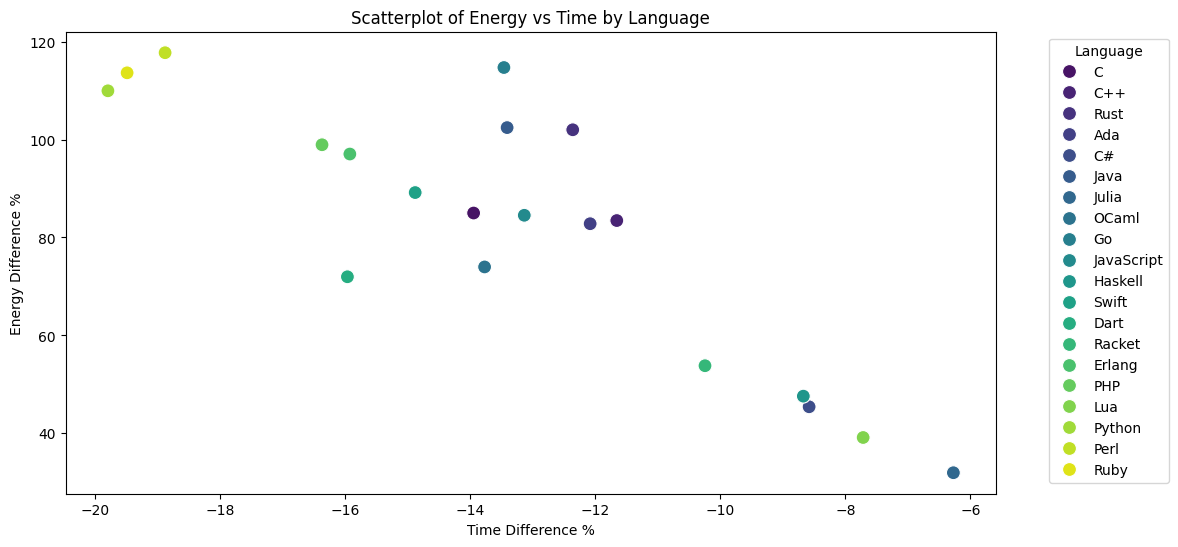

In [236]:
import seaborn as sns
# Criar o scatterplot
plt.figure(figsize=(12, 6))
scatter_plot = sns.scatterplot(y='Time Difference %', x='Energy Difference %', hue='Language', data=result_df_normalized, s=100, palette='viridis')

# Adicionar rótulos e título
plt.xlabel('Time Difference %')
plt.ylabel('Energy Difference %')
plt.title('Scatterplot of Energy vs Time by Language')

# Adicionar legenda
scatter_plot.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar o gráfico
plt.show()

/tmp/ipykernel_4468/1672285930.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Language', y='Energy Difference %', data=result_df_normalized, palette='viridis')


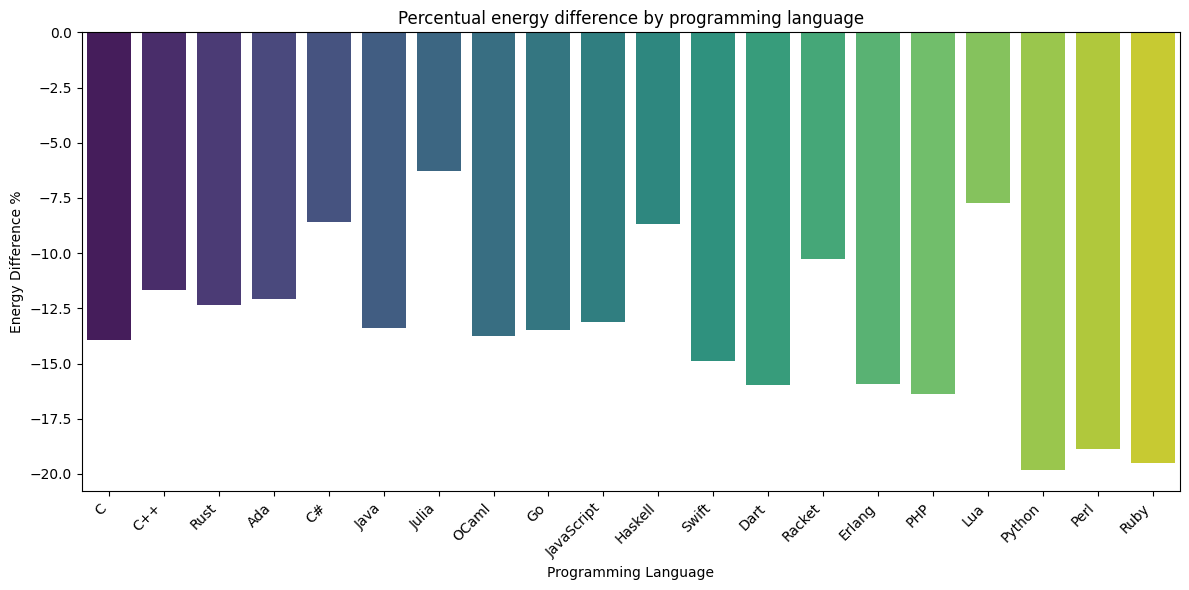

In [237]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criar o barplot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Language', y='Energy Difference %', data=result_df_normalized, palette='viridis')

# Adicionar rótulos e título
plt.xlabel('Programming Language')
plt.ylabel('Energy Difference %')
plt.title('Percentual energy difference by programming language')

# Rotacionar os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45, ha='right')

# Mostrar o gráfico
plt.tight_layout()
plt.show()
#TODO

/tmp/ipykernel_4468/250615788.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Language', y='Time Difference %', data=result_df_normalized, palette='viridis')


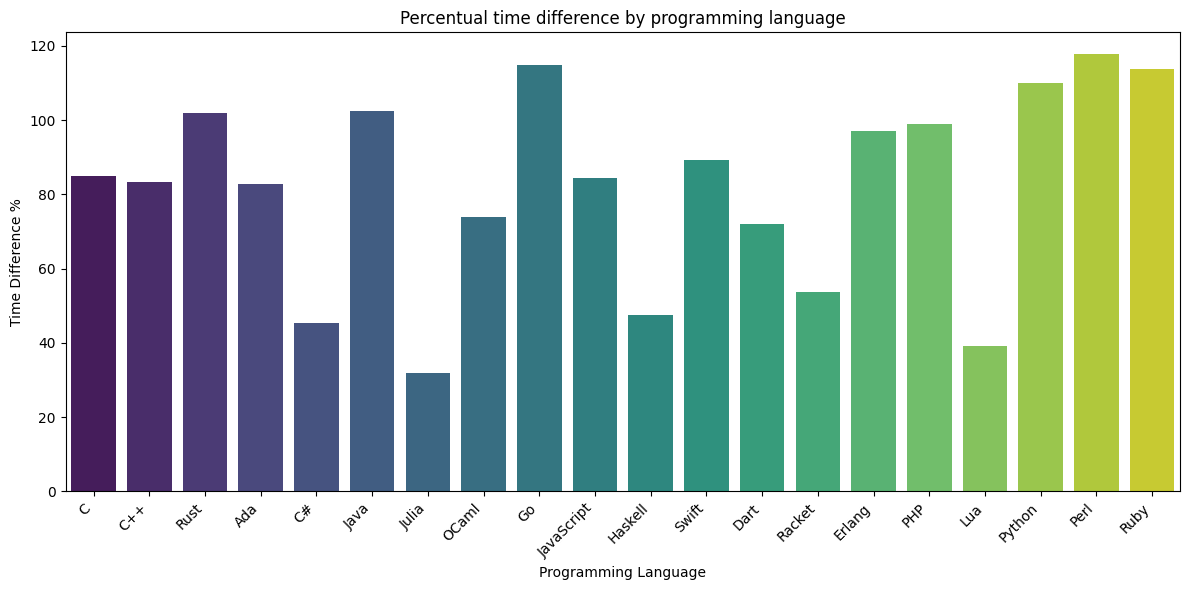

In [238]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criar o barplot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Language', y='Time Difference %', data=result_df_normalized, palette='viridis')

# Adicionar rótulos e título
plt.xlabel('Programming Language')
plt.ylabel('Time Difference %')
plt.title('Percentual time difference by programming language')

# Rotacionar os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45, ha='right')

# Mostrar o gráfico
plt.tight_layout()
plt.show()
#TODO

# Recuperação de valores

In [239]:
dfTratamento = df.drop(['GPU', 'Core','DRAM'], axis=1)
dfTratamento['PowerLimit'].replace(-1, 999, inplace=True)
dfTratamento = dfTratamento.loc[dfTratamento['Package'] <= 0]
dfTratamento = dfTratamento.loc[dfTratamento['PowerLimit'] == 25]

/tmp/ipykernel_4468/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


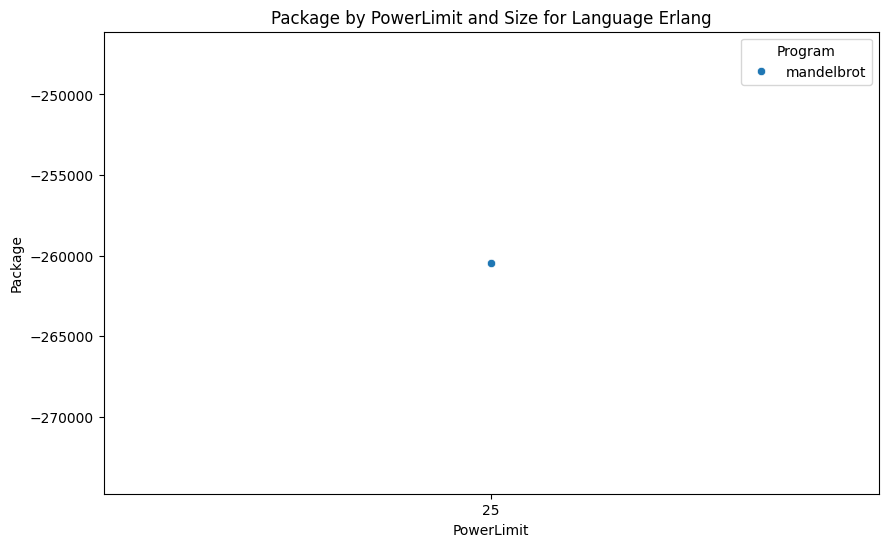

/tmp/ipykernel_4468/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

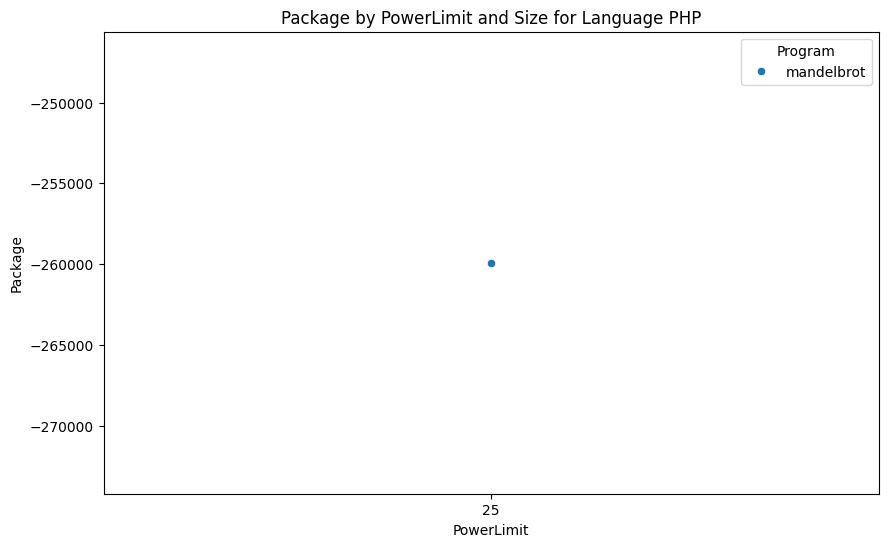

/tmp/ipykernel_4468/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


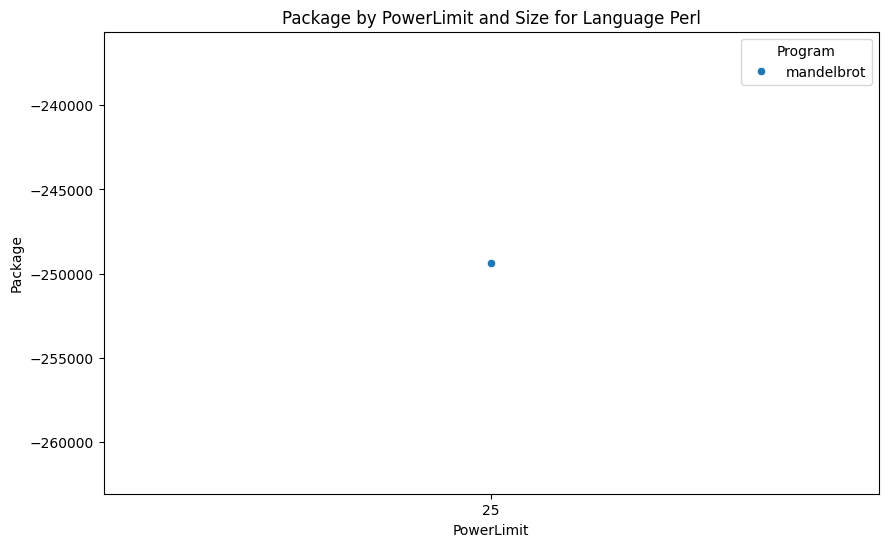

/tmp/ipykernel_4468/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

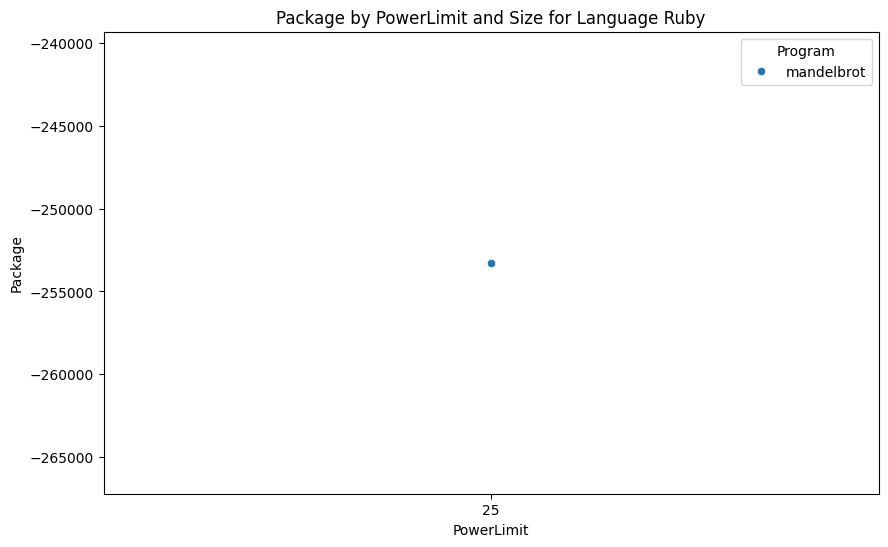

/tmp/ipykernel_4468/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

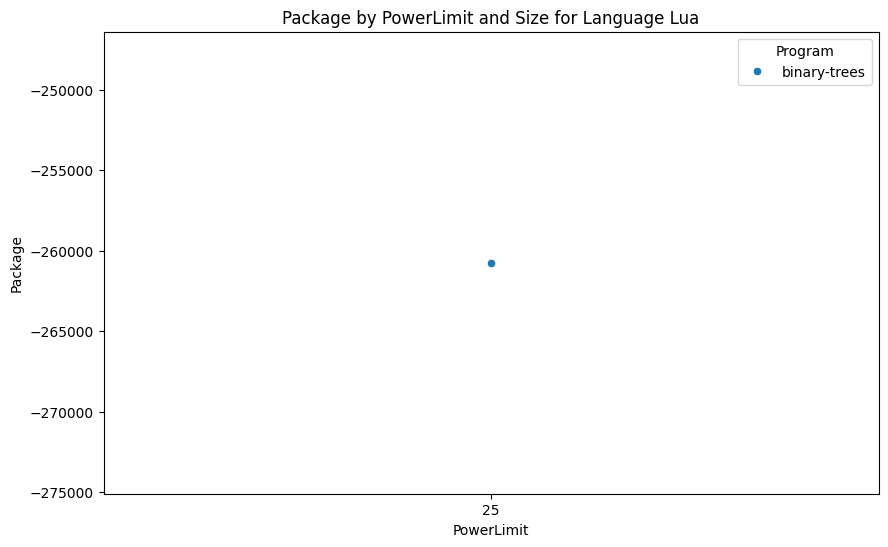

/tmp/ipykernel_4468/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

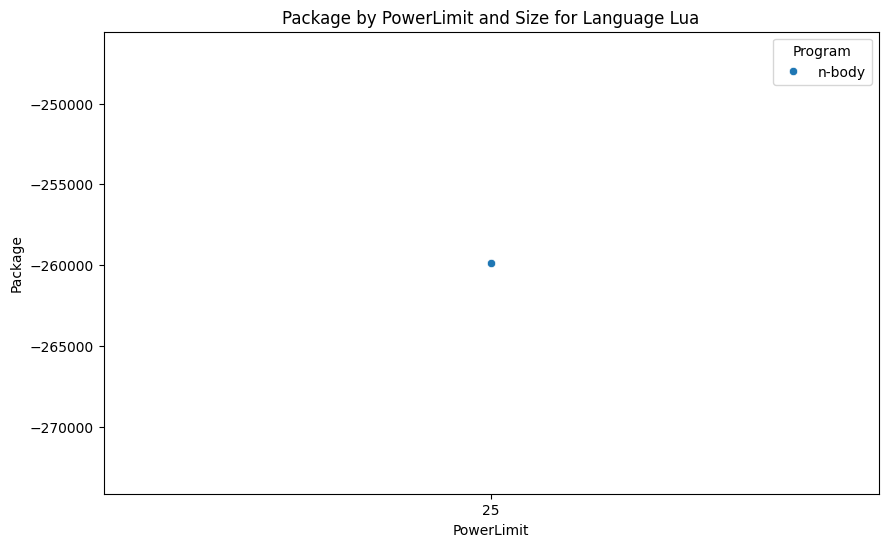

/tmp/ipykernel_4468/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

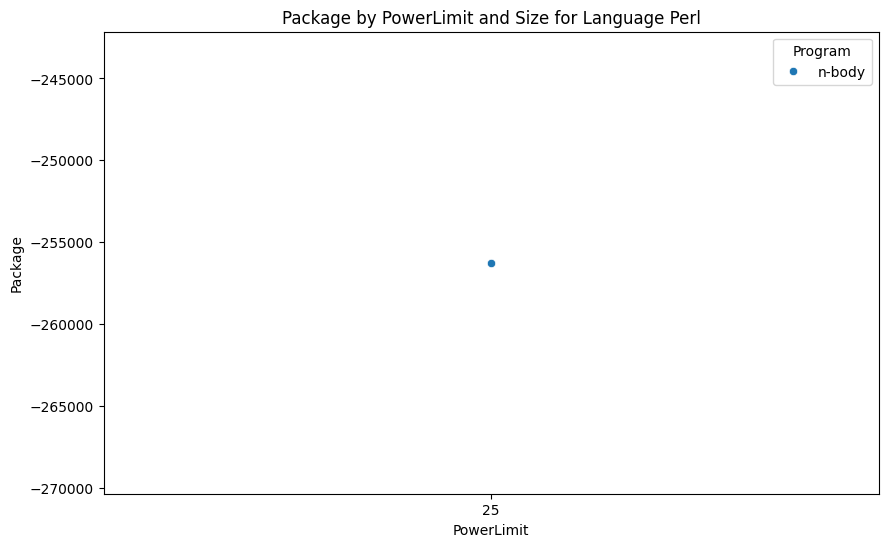

/tmp/ipykernel_4468/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


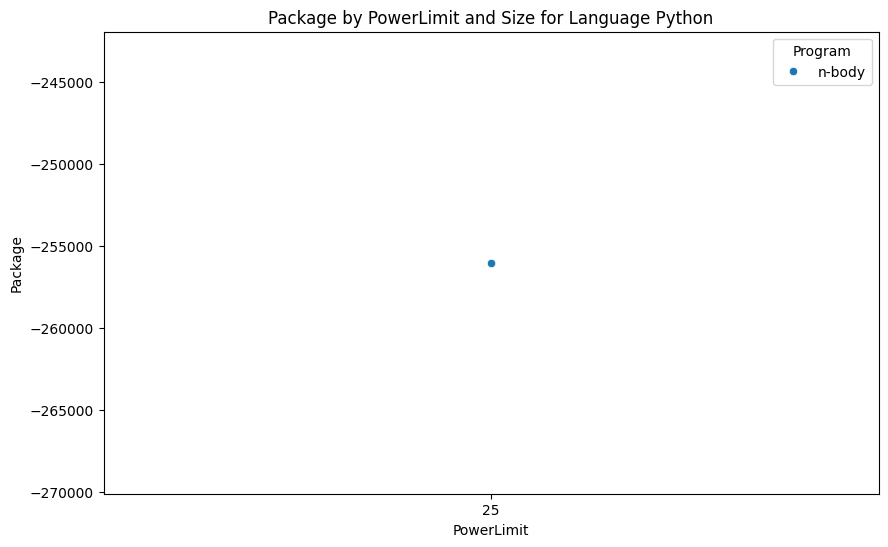

/tmp/ipykernel_4468/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

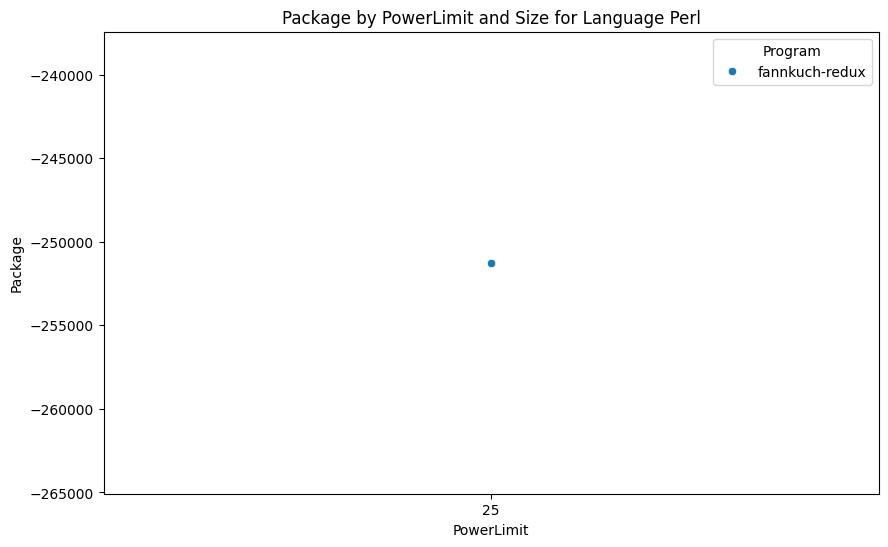

/tmp/ipykernel_4468/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


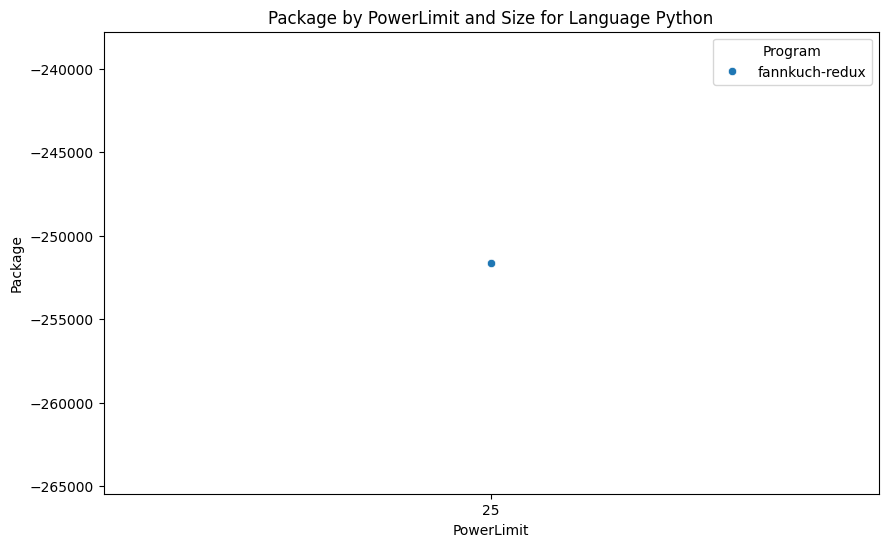

/tmp/ipykernel_4468/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


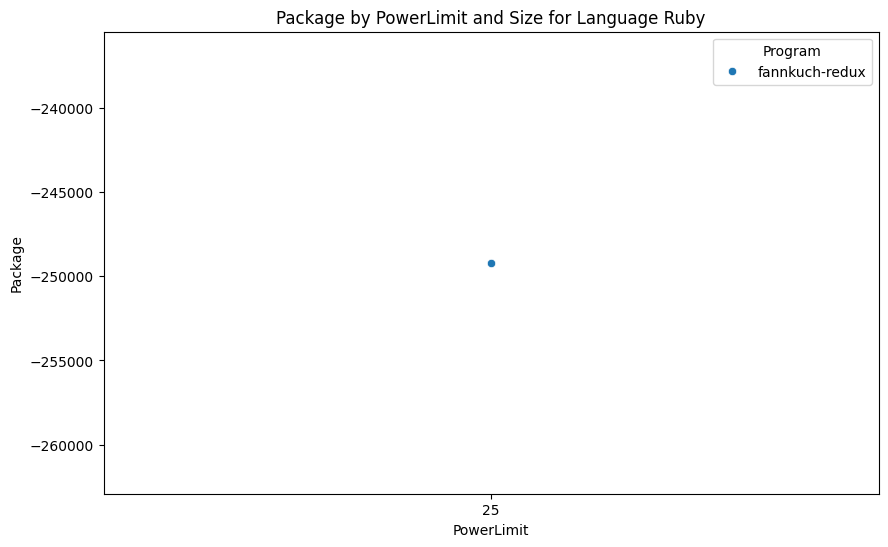

In [240]:
import matplotlib.pyplot as plt
import seaborn as sea

# Columns for comparison
#columns = ["Time", "Package", "Memory"]
columns = [ "Package"]
group_column = "PowerLimit"  # Specify the column to group by

# Iterate over the columns
for col in columns:
    programs = dfTratamento['Program'].unique()
    for program in programs:
        languages = dfTratamento['Language'].unique()
        for language in languages:
            plt.figure(figsize=(10, 6))
            
            data_subset = dfTratamento[(dfTratamento['Language'] == language) & (dfTratamento['Program'] == program)]
            if data_subset.shape[0]>0 :
                data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)

                ax = sea.scatterplot(data=data_subset, x=group_column, y=col, hue='Program')  # Add size='Size' parameter

                plt.xlabel(group_column)
                plt.ylabel(col)
                plt.title(f'{col} by {group_column} and Size for Language {language}')

                plt.legend(title='Program')
                plt.show()
